In [1]:
import random
from tqdm import tqdm
from PIL import Image, ImageFont, ImageDraw
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torchinfo import summary
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# torch.autograd.set_detect_anomaly(True)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cpu


## Prepare the Dataset

In [4]:
def create_pairs(x, digit_indices):
    '''
        Positive and negative pair creation.
        Alternates between positive and negative pairs.
    '''
    
    pairs = []
    labels = []
    # Get the array from list of arrays with minimum number of items
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            # From each array of arrays, take i, i+1 index
            # Since in an array, all indexes correspond to same label, they can form a pair
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            # Get image at those index and create a pair of images - same labels
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            # Get image from different arrays and create a pair of images - different labels
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            # Image pairs with same labels get a label of 1 and others a label of 0
            # That's why all even index have similar images and odd index different images
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    # This returns an array of arrays containing index of images with same labels
    # [[idx with label 0], [idx with label 1], ....]
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [5]:
# Image Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(1.,))
])

In [6]:
# Load Dataset
train_data = FashionMNIST(root='./', train=True, download=True, transform=transform)
test_data = FashionMNIST(root='./', train=False, download=True, transform=transform)

In [7]:
# Get raw train images and labels
train_images = train_data.data.numpy()
train_labels = train_data.targets.numpy()

print(train_images.shape, train_labels.shape)

(60000, 28, 28) (60000,)


In [8]:
# Get raw train images and labels
test_images = test_data.data.numpy()
test_labels = test_data.targets.numpy()

print(test_images.shape, test_labels.shape)

(10000, 28, 28) (10000,)


In [9]:
# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

In [10]:
tr_pairs.shape, tr_y.shape

((119980, 2, 28, 28), (119980,))

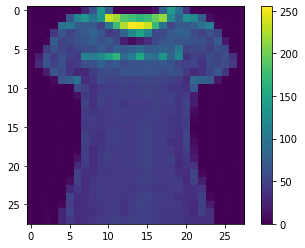

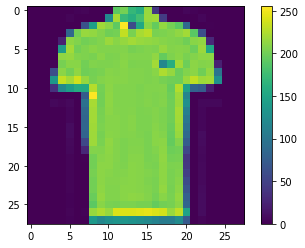

1.0


In [11]:
# array index
this_pair = 8

# show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# print the label for this pair
print(ts_y[this_pair])

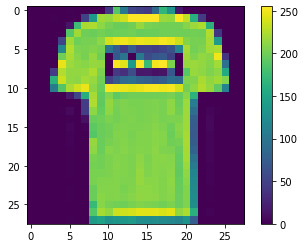

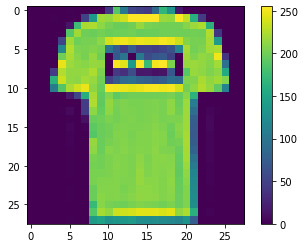

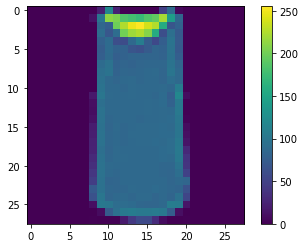

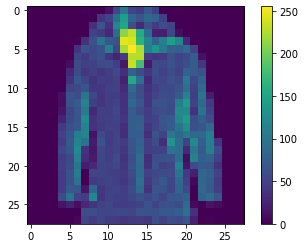

In [12]:
# print other pairs

# Similar Pairs
show_image(tr_pairs[:,0][0])
show_image(tr_pairs[:,0][1])

# Dissimilar Pairs
show_image(tr_pairs[:,1][0])
show_image(tr_pairs[:,1][1])

In [13]:
# Create Dataset & DataLoaders
tr_pairs_tensor = torch.Tensor(tr_pairs)
tr_y_tensor = torch.Tensor(tr_y)

ts_pairs_tensor = torch.Tensor(ts_pairs)
ts_y_tensor = torch.Tensor(ts_y)

In [14]:
# Dataset
train_dataset = TensorDataset(tr_pairs_tensor, tr_y_tensor)
val_dataset = TensorDataset(ts_pairs_tensor, ts_y_tensor)

In [15]:
# DataLoader
trainLoader = DataLoader(dataset=train_dataset, 
                         batch_size=32,
                         shuffle=True,
                         num_workers=4,
                         pin_memory=True)

valLoader = DataLoader(dataset=val_dataset,
                       batch_size=32,
                       shuffle=False,
                       num_workers=4,
                       pin_memory=True)

## Build the Model

In [16]:
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SiameseNetwork, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        self.layer1 = nn.Linear(in_features=self.input_dim, out_features=self.hidden_dim)
        self.layer2 = nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim)
        self.out = nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim)
        self.dropout = nn.Dropout(p=0.1)
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.relu3 = nn.ReLU(inplace=True)
    
    def forward_once(self, x):
        x = x.view(x.shape[0], -1)
        
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        
        x = self.out(x)
        out = self.relu3(x)
        
        return out
    
    def forward(self, x1, x2):
        out1 = self.forward_once(x1)
        out2 = self.forward_once(x2)
        
        return out1, out2

In [17]:
def initialize_base_network():
    model = SiameseNetwork(input_dim=784, hidden_dim=128)
    
    return model

In [18]:
model = initialize_base_network()
model.to(device)

SiameseNetwork(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu1): ReLU(inplace=True)
  (relu2): ReLU(inplace=True)
  (relu3): ReLU(inplace=True)
)

In [19]:
summary(model)

Layer (type:depth-idx)                   Param #
SiameseNetwork                           --
├─Linear: 1-1                            100,480
├─Linear: 1-2                            16,512
├─Linear: 1-3                            16,512
├─Dropout: 1-4                           --
├─ReLU: 1-5                              --
├─ReLU: 1-6                              --
├─ReLU: 1-7                              --
Total params: 133,504
Trainable params: 133,504
Non-trainable params: 0

## Contrastive Loss Formulation

![title](contrastive_loss.png)

## Contrastive Loss with Margin

In [20]:
class contrastive_loss(nn.Module):
    def __init__(self, margin):
        super(contrastive_loss, self).__init__()
        self.margin = margin
        self.pairwise_distance = nn.PairwiseDistance()
    
    def forward(self, y_pred1, y_pred2, y_true):
        euclidean_distance = self.pairwise_distance(y_pred1, y_pred2)
        loss = torch.mean(y_true * torch.square(self.margin - euclidean_distance) + 
                          (1 - y_true) * torch.square(euclidean_distance))
        
        return loss

## Train the Model

In [21]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
criterion = contrastive_loss(margin=1.0)

In [22]:
EPOCHS = 20

for epoch in tqdm(range(EPOCHS)):
    running_loss = 0
    for idx, data in enumerate(trainLoader):
        img, label = data
        img1, img2 = img[:,0], img[:,1]
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        
        optimizer.zero_grad()
        
        pred1, pred2 = model(img1, img2)
        loss = criterion(pred1, pred2, label)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Epoch: {epoch}, Loss: {running_loss/len(tr_pairs)}")

  5%|███                                                         | 1/20 [00:11<03:43, 11.76s/it]

Epoch: 0, Loss: 0.4827125618577371


 10%|██████                                                      | 2/20 [00:23<03:27, 11.55s/it]

Epoch: 1, Loss: 0.017530962940945707


 15%|█████████                                                   | 3/20 [00:35<03:23, 11.97s/it]

Epoch: 2, Loss: 0.015890534001179468


 20%|████████████                                                | 4/20 [00:48<03:18, 12.42s/it]

Epoch: 3, Loss: 0.01675181943953663


 25%|███████████████                                             | 5/20 [01:01<03:09, 12.63s/it]

Epoch: 4, Loss: 0.009471884815593344


 30%|██████████████████                                          | 6/20 [01:14<02:59, 12.79s/it]

Epoch: 5, Loss: 0.008719198697481499


 35%|█████████████████████                                       | 7/20 [01:28<02:48, 12.93s/it]

Epoch: 6, Loss: 0.008200297529502876


 40%|████████████████████████                                    | 8/20 [01:41<02:36, 13.02s/it]

Epoch: 7, Loss: 0.008110962768513315


 45%|███████████████████████████                                 | 9/20 [01:54<02:23, 13.09s/it]

Epoch: 8, Loss: 0.008104806269808876


 50%|█████████████████████████████▌                             | 10/20 [02:07<02:11, 13.14s/it]

Epoch: 9, Loss: 0.00809982290668753


 55%|████████████████████████████████▍                          | 11/20 [02:21<01:58, 13.20s/it]

Epoch: 10, Loss: 0.008094095953763931


 60%|███████████████████████████████████▍                       | 12/20 [02:34<01:45, 13.19s/it]

Epoch: 11, Loss: 0.008078650009445318


 65%|██████████████████████████████████████▎                    | 13/20 [02:47<01:32, 13.18s/it]

Epoch: 12, Loss: 0.008083204239492596


 70%|█████████████████████████████████████████▎                 | 14/20 [03:00<01:18, 13.17s/it]

Epoch: 13, Loss: 0.008089516333618409


 75%|████████████████████████████████████████████▎              | 15/20 [03:13<01:05, 13.13s/it]

Epoch: 14, Loss: 0.008088678952196594


 80%|███████████████████████████████████████████████▏           | 16/20 [03:26<00:52, 13.11s/it]

Epoch: 15, Loss: 0.008070174838889934


 85%|██████████████████████████████████████████████████▏        | 17/20 [03:39<00:39, 13.09s/it]

Epoch: 16, Loss: 0.008064128991181025


 90%|█████████████████████████████████████████████████████      | 18/20 [03:52<00:26, 13.08s/it]

Epoch: 17, Loss: 0.008053365880090965


 95%|████████████████████████████████████████████████████████   | 19/20 [04:05<00:13, 13.08s/it]

Epoch: 18, Loss: 0.008051462829296818


100%|███████████████████████████████████████████████████████████| 20/20 [04:18<00:00, 12.94s/it]

Epoch: 19, Loss: 0.008061980219518448


## Model Evaluation

In [23]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    
    pred = torch.ravel(y_pred) < 0.5
    
    return np.mean(pred == y_true)

In [24]:
model.eval()

SiameseNetwork(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu1): ReLU(inplace=True)
  (relu2): ReLU(inplace=True)
  (relu3): ReLU(inplace=True)
)

In [26]:
running_loss = 0
for idx, data in enumerate(valLoader):
    img, label = data
    img1, img2 = img[:,0], img[:,1]
    img1, img2, label = img1.to(device), img2.to(device), label.to(device)

    pred1, pred2 = model(img1, img2)
    loss = criterion(pred1, pred2, label)

    running_loss += loss.item()
print(f"Loss: {running_loss/len(tr_pairs)}")

Loss: 0.0026052027039079593
